# Medical Cost Analysis


## Reading the data

Firstly, we included some package we will use in our project and read our dataset.

- func has also been defined in another py file.


In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

import func


warnings.filterwarnings("ignore")


In [2]:
data = pd.read_csv('data/insurance.csv')
df = data.copy()
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Explonatary Data Analysis (EDA)

As a short summary of our dataframe, we can see we have 1338 entries and 10 attributes.

- We have no null data.
- While attributes of smoker, region and sex are category type, others are numerical.


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
# we can also check the null data of our dataset by isna function.
df.isna().sum()


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Measures of Central Tendency

We can check the measures of central tendency by describe() function.

- As we understand from here, bmi has lower std value than its min value. So bmi looks like normal distribution.
- Charges has bigger std value than its min value.


In [5]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


### Distribution of bmi


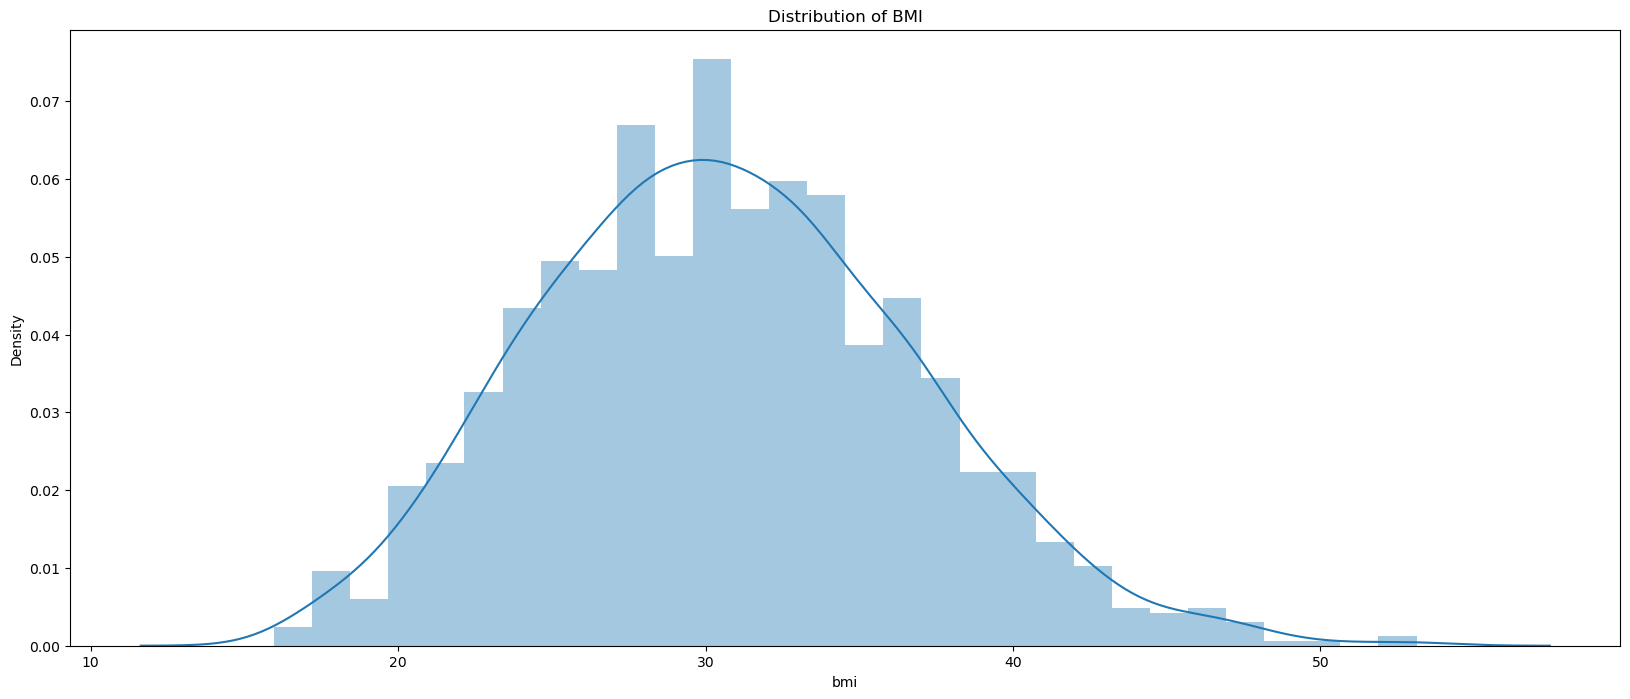

In [6]:
plt.figure(figsize=(20, 8))
sns.distplot(df.bmi, bins=30)
plt.title('Distribution of BMI')
plt.show()


### Distribution of Charges


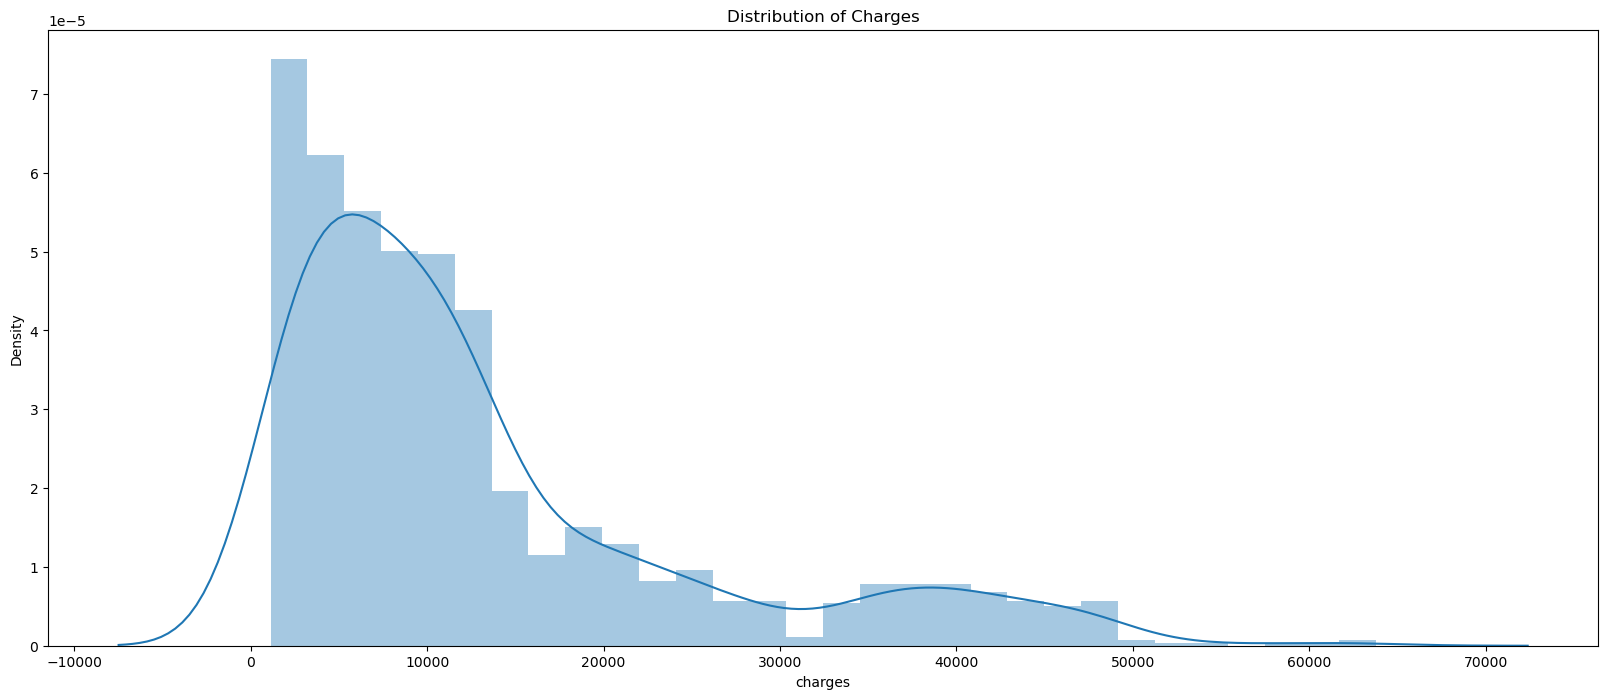

In [7]:
plt.figure(figsize=(20, 8))
sns.distplot(df.charges, bins=30)
plt.title('Distribution of Charges')
plt.show()


As we see, bmi looks like normal disribution but charges, also called target variable, looks like more positively skewed distribution. By applying natural log, we make it closer to normal.


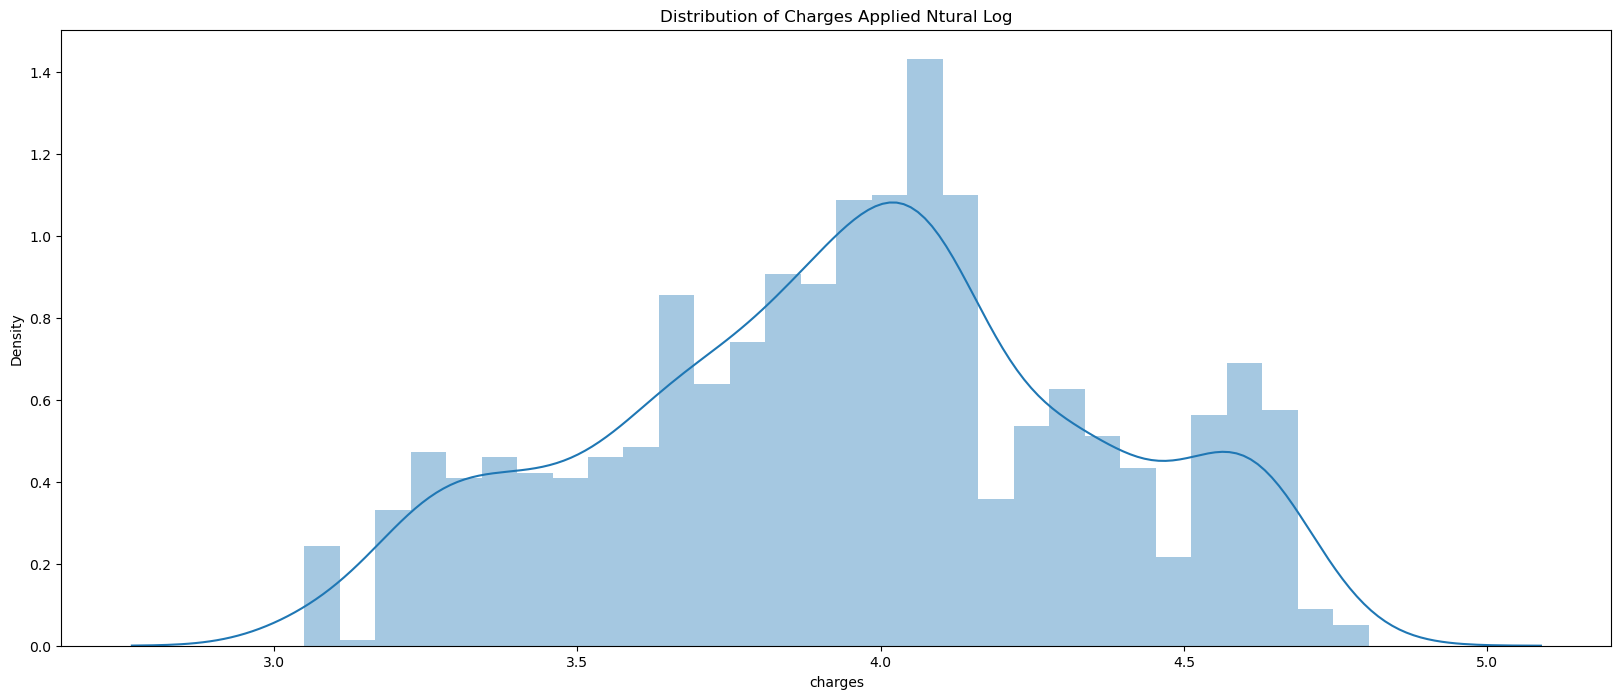

In [8]:
plt.figure(figsize=(20, 8))
sns.distplot(np.log10(df.charges), bins=30)
plt.title('Distribution of Charges Applied Ntural Log')
plt.show()


### Correlation


In [9]:
df['smoker'].unique()
df["region"].unique()
df["sex"].unique()


array(['female', 'male'], dtype=object)

In [10]:
# Converting type of columns to category
df['smoker'] = df['smoker'].astype('category')
df["region"] = df["region"].astype('category')
df["sex"] = df["sex"].astype('category')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.2 KB


In [11]:
# Assigning numerical values and storing it in another columns
df['n_smoker'] = df['smoker'].cat.codes
df["n_region"] = df["region"].cat.codes
df["n_sex"] = df["sex"].cat.codes
df.head()


,age,sex,bmi,children,smoker,region,charges,n_smoker,n_region,n_sex
0,19,female,27.900,0,yes,southwest,16884.92400,1,3,0
1,18,male,33.770,1,no,southeast,1725.55230,0,2,1
2,28,male,33.000,3,no,southeast,4449.46200,0,2,1
3,33,male,22.705,0,no,northwest,21984.47061,0,1,1
4,32,male,28.880,0,no,northwest,3866.85520,0,1,1


In [12]:
n_df=pd.get_dummies(df)

Text(0.5, 1.0, 'Correlation Heatmap between numerical attributes')

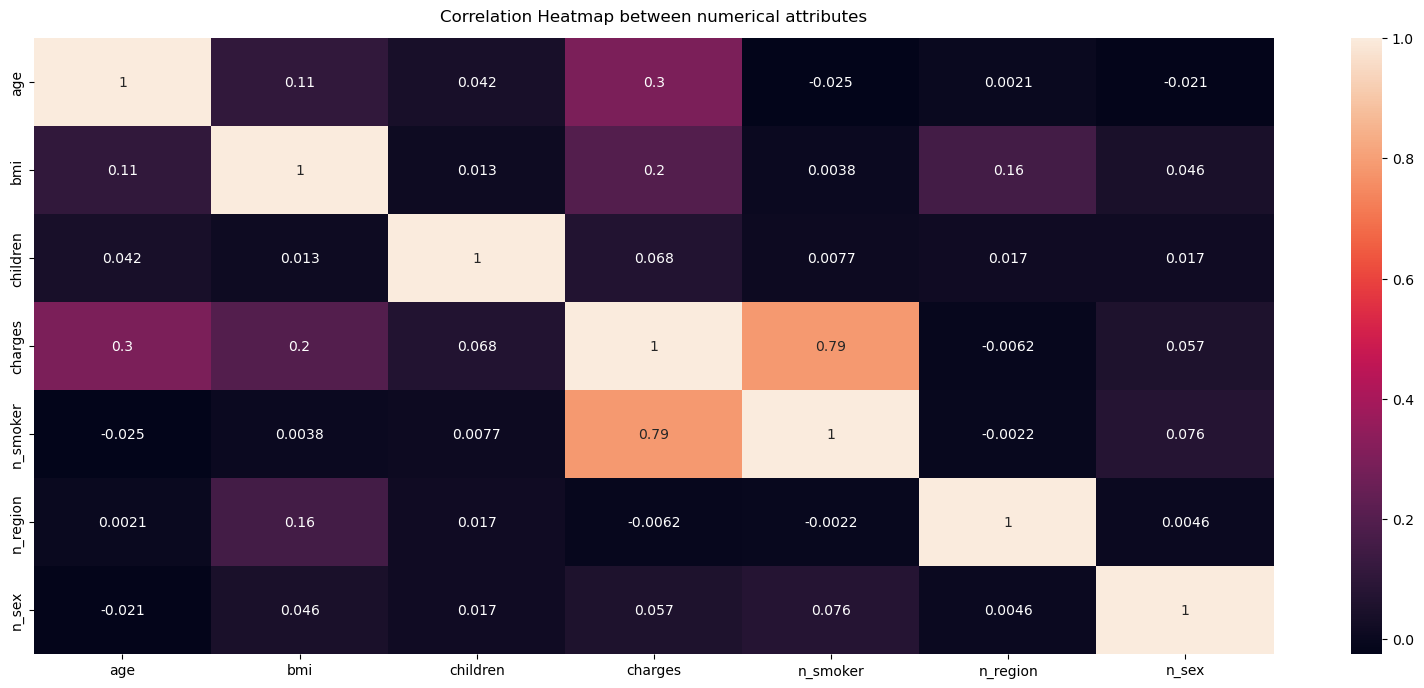

In [13]:
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(df.corr(), annot=True)
heatmap.set_title('Correlation Heatmap between numerical attributes', fontdict={
                  'fontsize': 12}, pad=12)


- `Smoker and Charges` are highly correlated to each other. (0.79)
- `Smoker and Region` relationship is under the threshold value of 0. We can say they are not related to each other.
- `BMI and Sex` relationship is above the threshold value of 0 but they have highly low relationship to each other.


### The region which has the maximum children count


In [14]:

ch = df.children.groupby(df.region)

region = []
count = []
for i in df.region.unique():
    region.append(i)
    count.append(ch.get_group(i).sum())
pd.DataFrame(region, columns=['region']).join(
    pd.DataFrame(count, columns=["count"]))


,region,count
0,southwest,371
1,southeast,382
2,northwest,373
3,northeast,339


### Is there any outlier in the bmi variable

- BMI variable has outliers

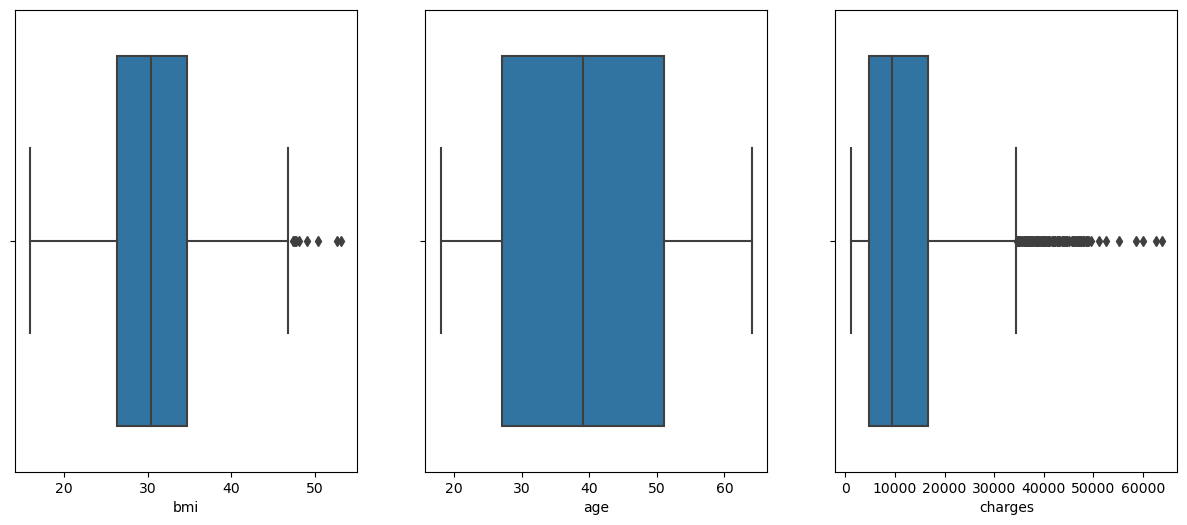

In [15]:
fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=3)
sns.boxplot(x=df.age, ax=axes[1])
sns.boxplot(x=df.bmi, ax=axes[0])

sns.boxplot(x=df.charges, ax=axes[2])
plt.show()


### The relationship between “region”, “smoker” and “bmi” using bar plot.

- We see that the number of people who smoke increases very small with age but in generally the number of smokers of all ages is high. 
- However, when we examine the smoker variable in general, we see that the data of non-smokers is low.
- When the graph is examined in a more detail, although the charges for young people who smoke are lower than those for older people who smoke, there is no huge difference between them. While the charges of the young non-smokers are low, the charges of the old non-smokers increase according to their age.

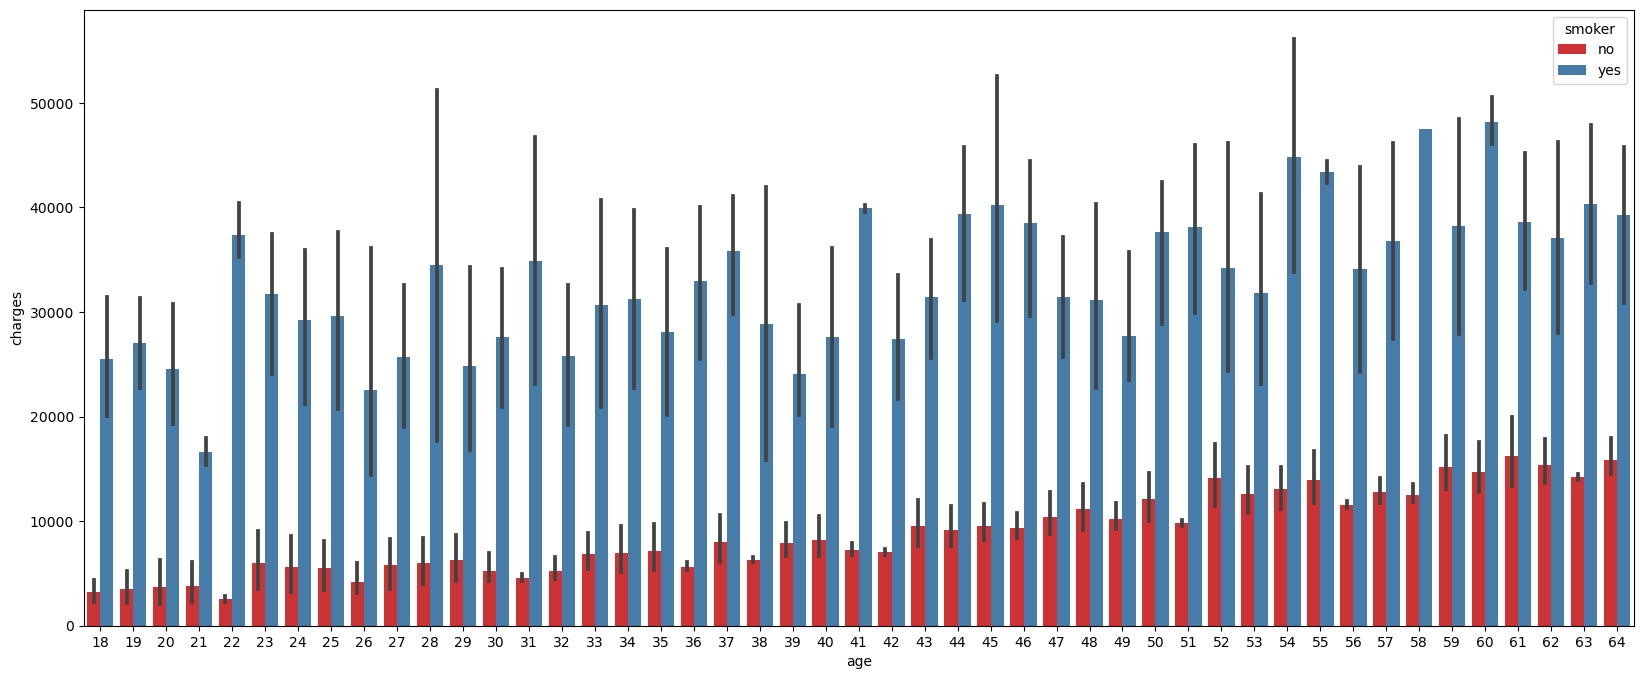

In [16]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x='age', y='charges', data=df, hue='smoker', palette='Set1')


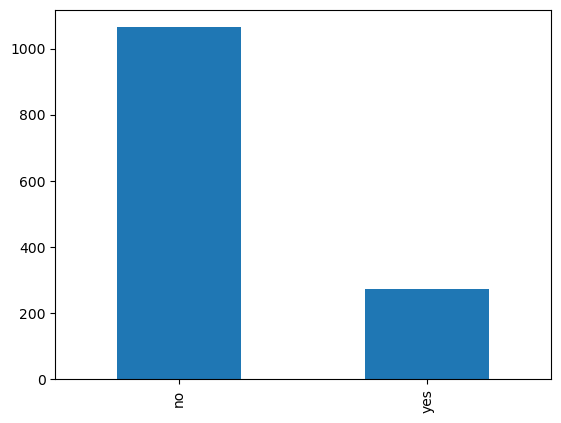

In [17]:
df['smoker'].value_counts().plot(kind='bar')


## Model
### Data Preprocessing

In [18]:
n_df

,age,bmi,children,charges,n_smoker,n_region,n_sex,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,3,0,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,2,1,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,2,1,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,0,1,1,0,1,1,0,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,0,1,0,1,0,1,0,0,0
1335,18,36.850,0,1629.83350,0,2,0,1,0,1,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,3,0,1,0,1,0,0,0,0,1


In [19]:
X = n_df.drop(['charges'], axis=1)
# X is our train data set

y = np.log10(n_df['charges'])
# y is our target dataset

X= StandardScaler().fit_transform(X)
# We normalized our train dataset

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
# We divided our dataset into test and training set.


### Model Selection

In [21]:
pipelines = {
    'rf': make_pipeline(RandomForestRegressor(random_state=42)),
    'gb': make_pipeline(GradientBoostingRegressor(random_state=42)),
    'ridge': make_pipeline(Ridge(random_state=42)),
    'svr': make_pipeline(SVR()),
}


In [22]:
params_grid  = {
    'rf':
    {
        'randomforestregressor__min_samples_split': [1, 2],
        'randomforestregressor__min_samples_leaf': [10],
    },

    'gb':
    {
        'gradientboostingregressor__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },

    'ridge':
    {
        'ridge__alpha': [0.001, 0.005, 0.01, 0.1, 0.5, 0.99]
    },

    'svr': {
        'svr__gamma': [1, 2]
    }
}


In [23]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, params_grid[algo], cv=10, n_jobs=-1)
    try:
        print(f'Starting training for {algo}')
        model.fit(X_train, y_train)
        fit_models[algo] = model
        print(f'{algo} has been successsfully fit.')
    except NotFittetError as e:
        print(repr(e))


Starting training for rf
rf has been successsfully fit.
Starting training for gb
gb has been successsfully fit.
Starting training for ridge
ridge has been successsfully fit.
Starting training for svr
svr has been successsfully fit.


#### Examine the metrics ​​for model selection.

In [24]:
from sklearn.model_selection import cross_val_score

In [63]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(f'{algo} scores - R2: {r2_score(y_test, yhat)}, mean_absolute_error:{mean_absolute_error(y_test, yhat)}, mean_squared_error: {np.sqrt(mean_squared_error(y_test,yhat))}')
    cv = cross_val_score(model, X=X, y=y, cv=10, scoring='r2', n_jobs=-1, )
    print("cross_val_score: ",np.mean(cv))

rf scores - R2: 0.8394793571290553, mean_absolute_error:0.08373946096351086, mean_squared_error: 0.1592268616447523
cross_val_score:  0.8357199281420365
gb scores - R2: 0.8367105060905198, mean_absolute_error:0.0838197237905163, mean_squared_error: 0.16059425741872624
cross_val_score:  0.8332784960936683
ridge scores - R2: 0.784450738059904, mean_absolute_error:0.11539728133940201, mean_squared_error: 0.184511806166813
cross_val_score:  0.7613351467557202
svr scores - R2: 0.7270242768779689, mean_absolute_error:0.1408215928333421, mean_squared_error: 0.2076409000076341
cross_val_score:  0.731547881697139


### Model

In [28]:
n_estimators = [int(x) for x in np.linspace(start = 90, stop = 700, num = 5)]
max_features = [1,2,3,4,5,6,7,8,9,10]
max_depth = [int(x) for x in np.linspace(10, 30, num = 10)]
max_depth.append(None)
min_samples_split = [1, 2,3,4,5,6,10,15]
min_samples_leaf = [1, 2,3,4,5,8,10]
bootstrap = [True, False]
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor(random_state=42)
gsc = GridSearchCV(rf, params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1).fit(X_train, y_train)
gsc.best_params_

Fitting 10 folds for each of 61600 candidates, totalling 616000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 11226 tasks      

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 8,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 242}

#### Model Tuning

In [74]:
rf_tuned = RandomForestRegressor(bootstrap=True,
                                 max_depth=20,
                                 max_features=6,
                                 min_samples_leaf=5,
                                 min_samples_split=3,   
                                 n_estimators=90, random_state=42)
model = rf_tuned.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
r2_score(y_test, y_pred)


0.16080483200804319


0.8362820080658417

In [66]:
rf_tuned_ = RandomForestRegressor()
model = rf_tuned_.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
r2_score(y_test, y_pred)


0.17085723457252028


0.8151731910767924